In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import shap

import warnings
warnings.filterwarnings("ignore")


In [2]:
train = pd.read_csv("/content/train_dataset_final1.csv")
test = pd.read_csv("/content/validate_dataset_final.csv")

print(train.shape, test.shape)
train.head()


(25247, 27) (5016, 26)


,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


In [3]:
train.drop("Customer_ID", axis=1, inplace=True)
test_id = test["Customer_ID"]    #For validation purposes only
test.drop("Customer_ID", axis=1, inplace=True)

In [4]:
train.isna().sum()

,0
marriage,0
sex,0
education,0
LIMIT_BAL,0
age,126
pay_0,0
pay_2,0
pay_3,0
pay_4,0
pay_5,0


In [5]:
train["age"].fillna(train["age"].median(), inplace=True)

In [6]:
train["marriage"].unique()

array([2, 1, 3, 0])

In [7]:
train['marriage'].value_counts()

,count
marriage,
2,13441
1,11480
3,273
0,53


In [8]:
train["sex"].unique()

array([0, 1])

In [9]:
train["education"].unique()

array([2, 1, 3, 4, 5, 6, 0])

In [10]:
train['education'].value_counts()

,count
education,
2,11717
1,8988
3,4115
5,253
4,116
6,44
0,14


# **Handling Discrepancies**

In [11]:
# Map 0, 5, 6 to 4 (Others) as they don't fall into 1–3
train['education'] = train['education'].replace({0: 4, 5: 4, 6: 4})
test['education'] = test['education'].replace({0: 4, 5: 4, 6: 4})

In [12]:
train['education'].value_counts()

,count
education,
2,11717
1,8988
3,4115
4,427


In [13]:
# Mapping 0 to 3 ("Others")
train['marriage'] = train['marriage'].replace({0: 3})
test['marriage'] = test['marriage'].replace({0: 3})

In [14]:
train['marriage'].value_counts()

,count
marriage,
2,13441
1,11480
3,326


# **Feature Engineering**

In [15]:
#Measures how much of the credit limit is typically used — high values imply financial stress.
train["avg_bill_amt"] = train[[f"Bill_amt{i}" for i in range(1, 7)]].mean(axis=1)
train["credit_utilization"] = train["avg_bill_amt"] / (train["LIMIT_BAL"] + 1)

test["avg_bill_amt"] = test[[f"Bill_amt{i}" for i in range(1, 7)]].mean(axis=1)
test["credit_utilization"] = test["avg_bill_amt"] / (test["LIMIT_BAL"] + 1)

In [16]:
# Delinquency Streak (Consecutive Overdue Months): Continuous overdue behavior is a red flag even if amount owed is small.
pay_cols = [f"pay_{i}" for i in [0, 2, 3, 4, 5, 6]]

def delinquency_streak(row):
    binary_seq = [1 if row[col] >= 1 else 0 for col in pay_cols]
    max_streak = 0
    current_streak = 0
    for val in binary_seq:
        if val == 1:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    return max_streak

train["delinquency_streak"] = train.apply(delinquency_streak, axis=1)

test["delinquency_streak"] = test.apply(delinquency_streak, axis=1)

In [17]:
#Minimum Payment Behavior (Partial Payments Count): Repeated minimum payments suggest poor repayment discipline.
train["min_payment_count"] = train[pay_cols].apply(lambda row: sum(val == 0 for val in row), axis=1)

test["min_payment_count"] = test[pay_cols].apply(lambda row: sum(val == 0 for val in row), axis=1)

In [18]:
#Repayment Consistency (Std Dev of PAY Status): Volatile payers (sometimes delay, sometimes not) are harder to trust.
train["repayment_variability"] = train[pay_cols].std(axis=1)

test["repayment_variability"] = test[pay_cols].std(axis=1)

In [19]:
#Overpayment Behavior: People who pay more than billed often carry forward credits → very low default probability.

# Count of months where Pay_amt > Bill_amt
overpaid = train[[f"pay_amt{i}" for i in range(1, 7)]].values > train[[f"Bill_amt{i}" for i in range(1, 7)]].values
train["overpayment_count"] = overpaid.sum(axis=1)

overpaid_test = test[[f"pay_amt{i}" for i in range(1, 7)]].values > test[[f"Bill_amt{i}" for i in range(1, 7)]].values
test["overpayment_count"] = overpaid_test.sum(axis=1)

In [20]:
train.head()

,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default,avg_bill_amt,credit_utilization,delinquency_streak,min_payment_count,repayment_variability,overpayment_count
0,2,0,2,60000,25.0,2,2,2,0,0,...,1500.24,41511.50,0.03,0,41511.498333,0.691847,3,3,1.095445,0
1,2,1,1,290000,24.0,0,0,-2,-2,-1,...,1349.72,2534.50,0.27,0,2535.076667,0.008742,0,3,0.983192,2
2,1,0,2,180000,63.0,0,0,0,0,0,...,1999.78,50422.00,0.04,0,50421.683333,0.280119,0,6,0.000000,0
3,1,1,2,210000,43.0,0,0,0,0,0,...,2892.10,86229.50,0.04,0,86229.755000,0.410616,0,6,0.000000,0
4,2,0,1,280000,32.0,-2,-2,-2,-2,-2,...,0.27,11814.33,0.72,0,11814.253333,0.042194,0,0,0.000000,2


In [21]:
test.head()

,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,avg_bill_amt,credit_utilization,delinquency_streak,min_payment_count,repayment_variability,overpayment_count
0,1,1,2,220000,32,0,0,0,0,0,...,3000.21,30788.71,23456.33,0.31,23456.343333,0.106619,0,6,0.000000,1
1,2,0,1,350000,35,-1,-1,-1,0,0,...,1565.11,26346.39,13660.33,1.00,13660.160000,0.039029,0,3,0.547723,2
2,2,1,1,310000,39,0,0,0,0,0,...,10000.16,10000.21,258034.17,0.04,258034.261667,0.832366,0,6,0.000000,0
3,1,0,2,20000,47,0,0,0,2,2,...,0.02,1000.26,13333.33,0.08,13333.243333,0.666629,3,3,1.095445,0
4,2,1,2,500000,30,0,0,0,0,0,...,8841.07,12000.21,77204.50,0.23,77204.711667,0.154409,0,6,0.000000,0


In [22]:
y = train["next_month_default"]
X = train.drop("next_month_default", axis=1)

# **Exploratory Data Analysis**

In [23]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
marriage,25247.0,1.558205,0.521965,1.00,1.000000,2.000000,2.000000,3.000000e+00
sex,25247.0,0.604111,0.489050,0.00,0.000000,1.000000,1.000000,1.000000e+00
education,25247.0,1.840813,0.749217,1.00,1.000000,2.000000,2.000000,4.000000e+00
LIMIT_BAL,25247.0,168342.060443,129892.784807,10000.00,50000.000000,140000.000000,240000.000000,1.000000e+06
age,25247.0,35.431022,9.152635,21.00,28.000000,34.000000,41.000000,7.900000e+01
pay_0,25247.0,-0.042857,1.099315,-2.00,-1.000000,0.000000,0.000000,8.000000e+00
pay_2,25247.0,-0.159544,1.173990,-2.00,-1.000000,0.000000,0.000000,8.000000e+00
pay_3,25247.0,-0.190359,1.172636,-2.00,-1.000000,0.000000,0.000000,8.000000e+00
pay_4,25247.0,-0.241415,1.146753,-2.00,-1.000000,0.000000,0.000000,7.000000e+00
pay_5,25247.0,-0.282568,1.114213,-2.00,-1.000000,0.000000,0.000000,7.000000e+00


In [24]:
# Target Distribution
print("Target distribution:")
print(y.value_counts(normalize=True))

Target distribution:
next_month_default
0    0.809601
1    0.190399
Name: proportion, dtype: float64


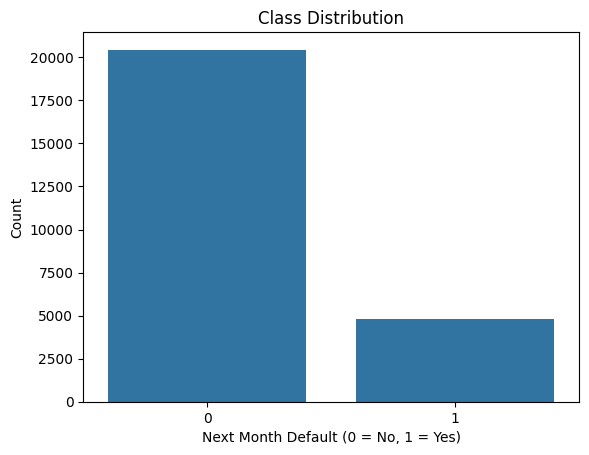

In [25]:
# Plotting class imbalance
sns.countplot(x=y)
plt.title("Class Distribution")
plt.xlabel("Next Month Default (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [26]:
train.groupby('sex')['next_month_default'].mean()        #default rate by gender

,next_month_default
sex,
0,0.208604
1,0.178468


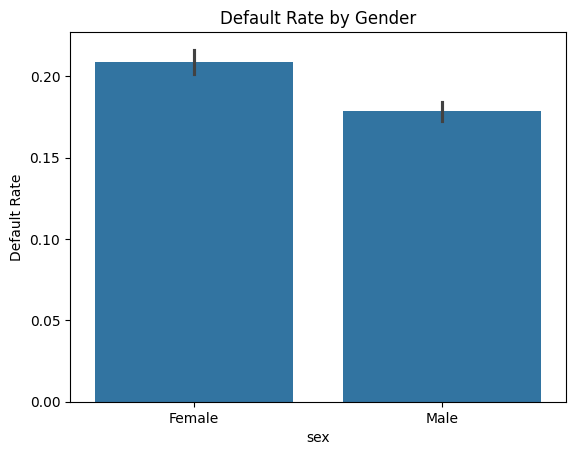

In [27]:
# Gender vs Default
sns.barplot(x="sex", y=y, data=pd.concat([X, y], axis=1))
plt.title("Default Rate by Gender")
plt.xticks([0, 1], ["Female", "Male"])
plt.ylabel("Default Rate")
plt.show()

In [28]:
train.groupby('marriage')['next_month_default'].mean()        #default rate by marriage

,next_month_default
marriage,
1,0.203746
2,0.178856
3,0.196319


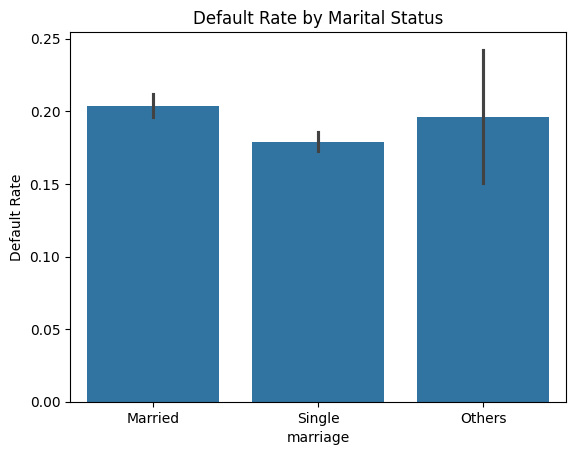

In [29]:
# Marital Status vs Default
sns.barplot(x="marriage", y=y, data=pd.concat([train, y], axis=1))
plt.title("Default Rate by Marital Status")
plt.xticks([0, 1, 2], ["Married", "Single", "Others"])
plt.ylabel("Default Rate")
plt.show()

In [30]:
train.groupby('education')['next_month_default'].mean()        #default rate by education

,next_month_default
education,
1,0.161771
2,0.209098
3,0.213123
4,0.060890


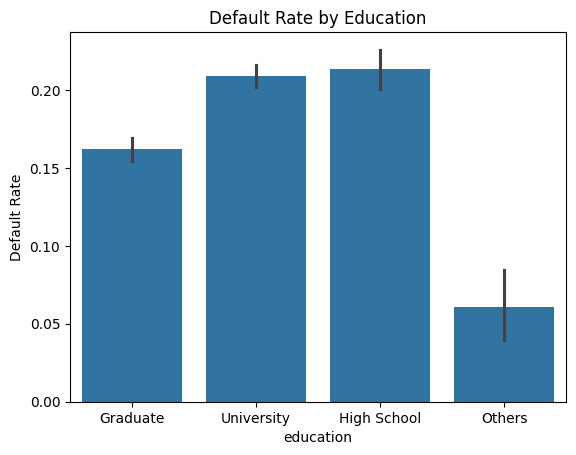

In [31]:
# Education vs Default
sns.barplot(x="education", y=y, data=pd.concat([X, y], axis=1))
plt.title("Default Rate by Education")
plt.xticks([0, 1, 2, 3], ["Graduate", "University", "High School", "Others"])
plt.ylabel("Default Rate")
plt.show()

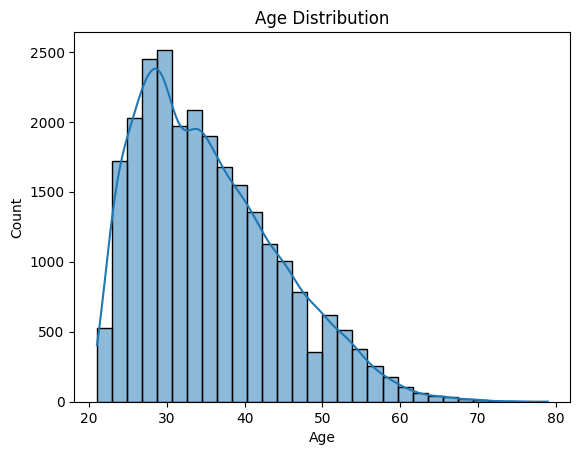

In [32]:
# Age Distribution
sns.histplot(X["age"], kde=True, bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.show()

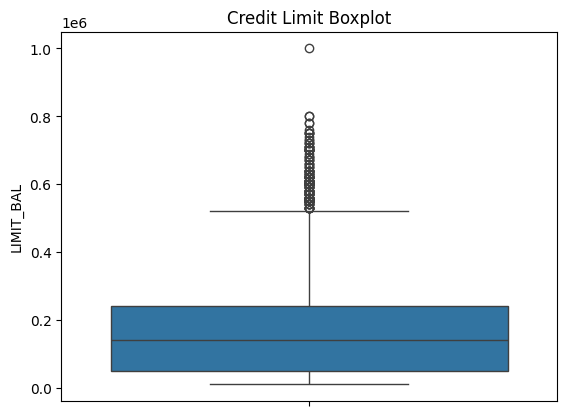

In [33]:
# Credit Limit
sns.boxplot(y="LIMIT_BAL", data=X)
plt.title("Credit Limit Boxplot")
plt.show()

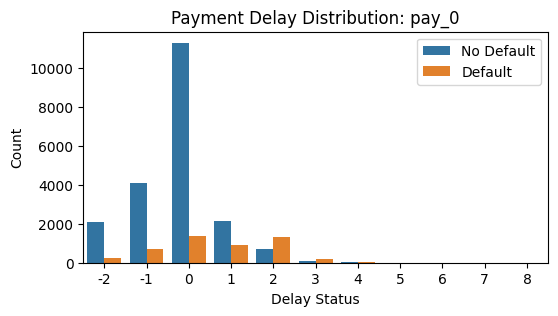

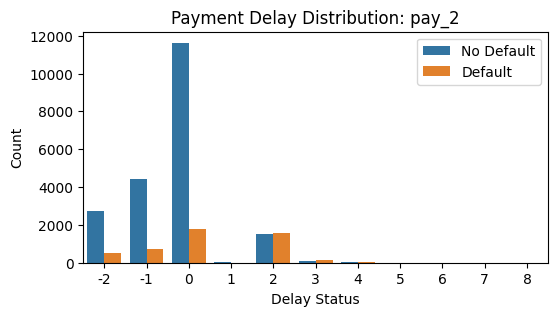

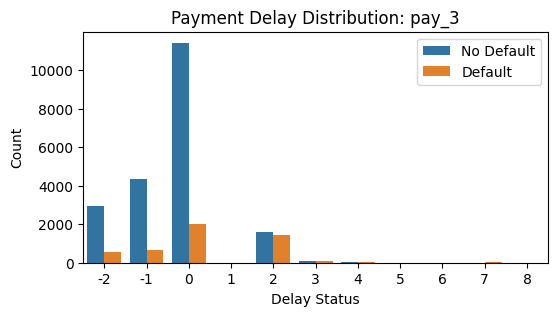

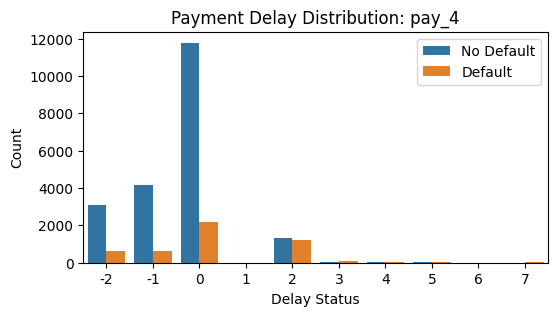

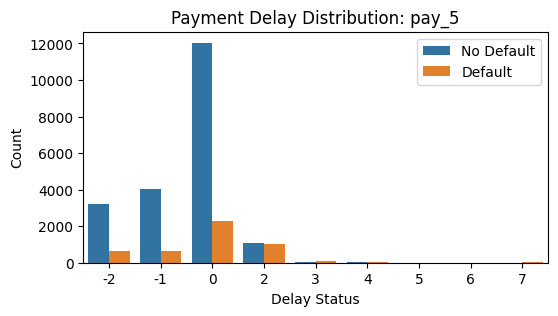

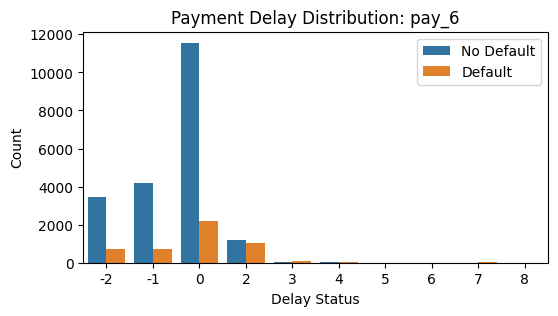

In [34]:
# Payment delay status visualizations
pay_cols = [f"pay_{i}" for i in [0, 2, 3, 4, 5, 6]]
X_pay = X[pay_cols].copy()
X_pay["default"] = y

for col in pay_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, hue="default", data=X_pay)
    plt.title(f"Payment Delay Distribution: {col}")
    plt.xlabel("Delay Status")
    plt.ylabel("Count")
    plt.legend(["No Default", "Default"])
    plt.show()

PAY_0 and PAY_2 have the highest correlation with default.

Higher delay values (≥1) strongly correlate with default.

Users consistently delaying payments (even by 1 month) are higher risk.
#Financial Insight: Higher delay values (≥1) are strongly associated with default. PAY_0 (most recent month) is the most influential.

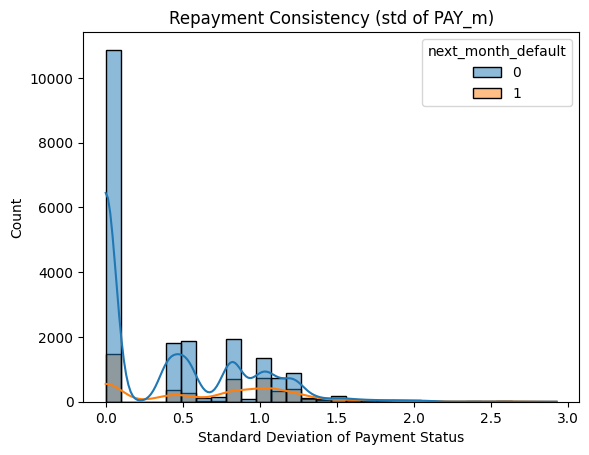

In [35]:
sns.histplot(data=X, x="repayment_variability", hue=y, kde=True, bins=30)
plt.title("Repayment Consistency (std of PAY_m)")
plt.xlabel("Standard Deviation of Payment Status")
plt.ylabel("Count")
plt.show()

Higher variability → irregular repayment behavior → more likely to default.

Customers with low standard deviation (e.g., always pay on time or consistently pay late) have predictable risk.


In [36]:
# Bill and payment amounts over months
bill_cols = [f"Bill_amt{i}" for i in range(1, 7)]
pay_cols = [f"pay_amt{i}" for i in range(1, 7)]

X_bill = X[bill_cols].copy()
X_pay_amt = X[pay_cols].copy()

X_bill["default"] = y
X_pay_amt["default"] = y

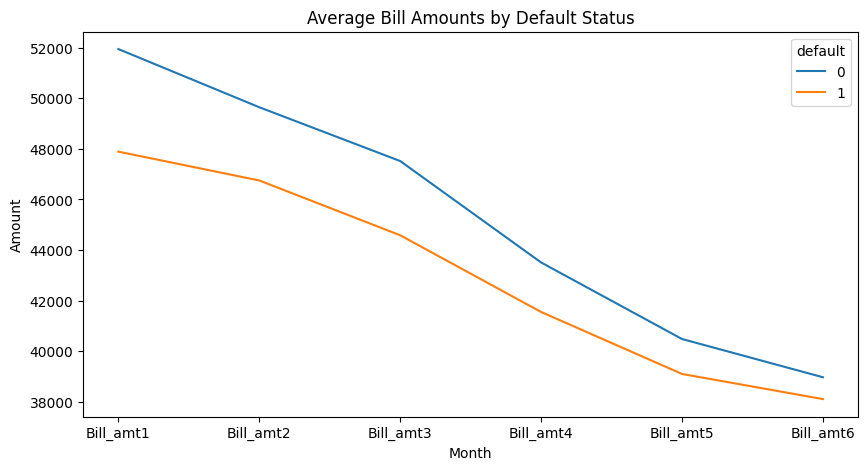

In [37]:
# Avg bill per month
bill_avg = X_bill.groupby("default").mean().T
bill_avg.plot(figsize=(10, 5), title="Average Bill Amounts by Default Status")
plt.xlabel("Month")
plt.ylabel("Amount")
plt.show()

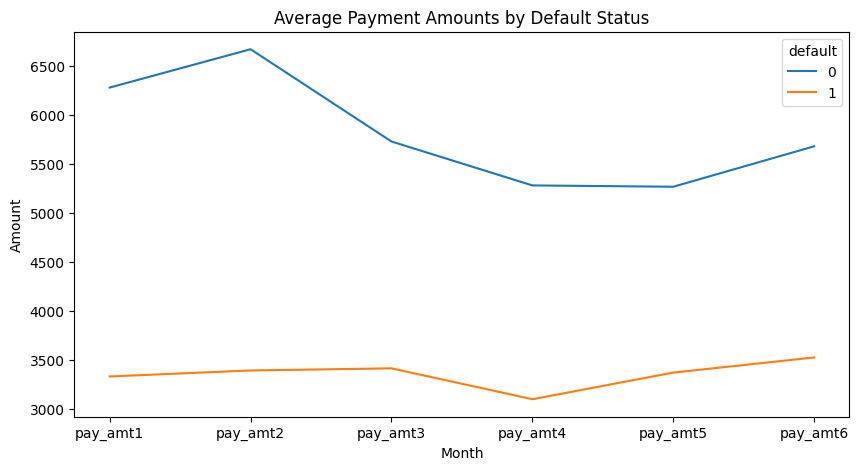

In [38]:
# Avg payment per month
pay_avg = X_pay_amt.groupby("default").mean().T
pay_avg.plot(figsize=(10, 5), title="Average Payment Amounts by Default Status")
plt.xlabel("Month")
plt.ylabel("Amount")
plt.show()

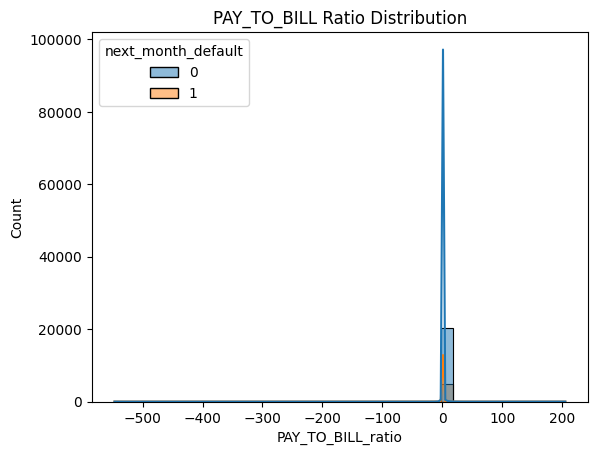

In [39]:
sns.histplot(data=X, x="PAY_TO_BILL_ratio", hue=y, kde=True, bins=40)
plt.title("PAY_TO_BILL Ratio Distribution")
plt.show()

Current histogram is being skewed due to extreme outliers in the PAY_TO_BILL_ratio column (e.g., values like -500 and +200), which compresses the visible distribution near zero and makes the plot unclear.

In [40]:
# Clip extreme values for clearer visualization (e.g., -50 to 50)
X_clipped = X[(X["PAY_TO_BILL_ratio"] >= 0) & (X["PAY_TO_BILL_ratio"] <= 2)]
X_clipped["PAY_TO_BILL_ratio"].describe().T

,PAY_TO_BILL_ratio
count,24732.000000
mean,0.320829
std,0.401222
min,0.000000
25%,0.040000
50%,0.080000
75%,0.550000
max,2.000000


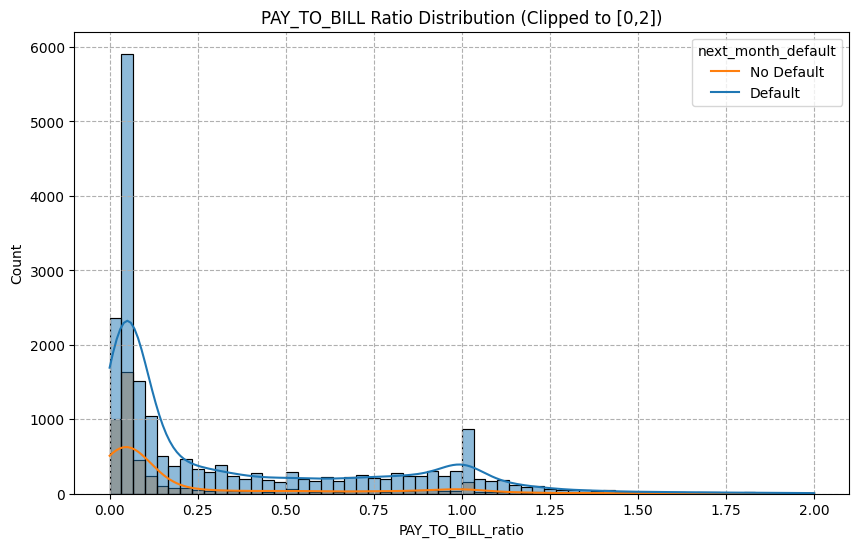

In [41]:
# PAY_TO_BILL Ratio Distribution
plt.figure(figsize=(10, 6))
sns.histplot(
    data=X_clipped,
    x="PAY_TO_BILL_ratio",
    hue=y.loc[X_clipped.index],  # ensure y aligns with filtered x
    kde=True,
    bins=60,
    alpha=0.5
)

plt.title("PAY_TO_BILL Ratio Distribution (Clipped to [0,2])")
plt.xlabel("PAY_TO_BILL_ratio")
plt.ylabel("Count")
plt.legend(title="next_month_default", labels=["No Default", "Default"])
plt.grid(True, linestyle='--', alpha=1)
plt.show()

 Insight: A low payment-to-bill ratio is linked with higher default risk, signaling poor repayment discipline.

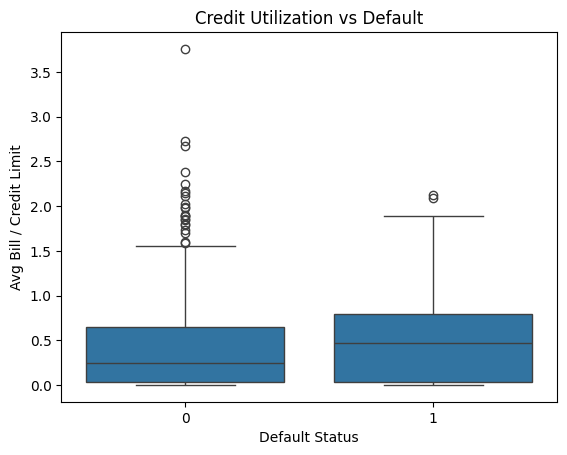

In [42]:
# Feature: average utilization = avg_bill / credit limit
bill_cols = [f"Bill_amt{i}" for i in range(1, 7)]
X["avg_bill_amt"] = X[bill_cols].mean(axis=1)
X["credit_utilization"] = X["avg_bill_amt"] / (X["LIMIT_BAL"] + 1)

# Visualize
sns.boxplot(x=y, y="credit_utilization", data=X)
plt.title("Credit Utilization vs Default")
plt.xlabel("Default Status")
plt.ylabel("Avg Bill / Credit Limit")
plt.show()


Higher utilization ratio → financially stretched → higher probability of default.

Customers using >80% of their limit regularly are high-risk.

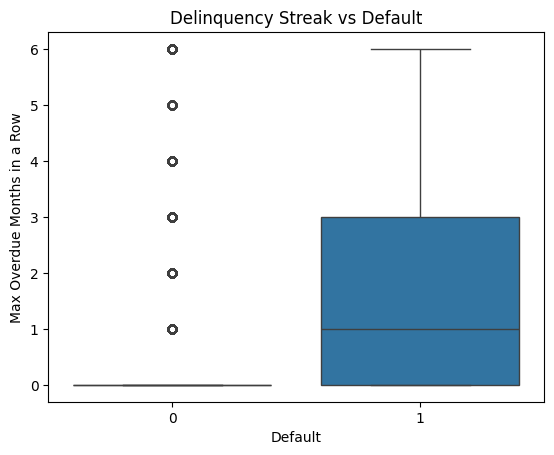

In [43]:
sns.boxplot(x=y, y="delinquency_streak", data=X)
plt.title("Delinquency Streak vs Default")
plt.xlabel("Default")
plt.ylabel("Max Overdue Months in a Row")
plt.show()


Long consecutive delays (streak ≥ 2) significantly increase default risk.

Captures chronic non-payment better than just recent month status.

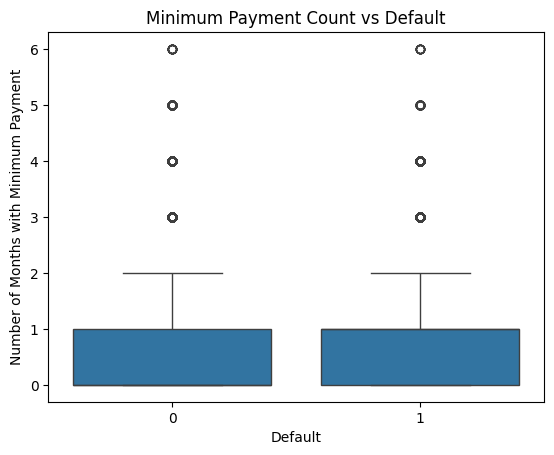

In [44]:
# PAY_m == 0 means partial/minimum payment
X["min_payment_count"] = X[pay_cols].apply(lambda row: sum(val == 0 for val in row), axis=1)

sns.boxplot(x=y, y="min_payment_count", data=X)
plt.title("Minimum Payment Count vs Default")
plt.xlabel("Default")
plt.ylabel("Number of Months with Minimum Payment")
plt.show()


Making only minimum payments frequently is a red flag → user is in financial strain.

Users with 3+ minimum-only months are more likely to default.

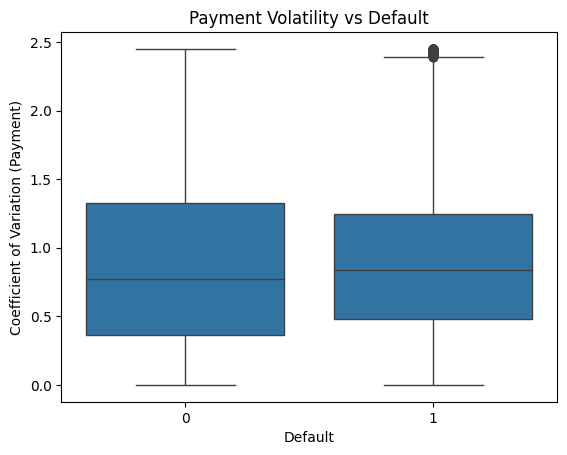

In [45]:
pay_cols_amt = [f"pay_amt{i}" for i in range(1, 7)]
bill_cols_amt = [f"Bill_amt{i}" for i in range(1, 7)]

# Define coefficient of variation (std / mean)
X["pay_cv"] = X[pay_cols_amt].std(axis=1) / (X[pay_cols_amt].mean(axis=1) + 1)
X["bill_cv"] = X[bill_cols_amt].std(axis=1) / (X[bill_cols_amt].mean(axis=1) + 1)

# Payment volatility higher → riskier
sns.boxplot(x=y, y="pay_cv", data=X)
plt.title("Payment Volatility vs Default")
plt.xlabel("Default")
plt.ylabel("Coefficient of Variation (Payment)")
plt.show()


Irregular or erratic payment patterns (high CoV) reflect instability.

Stable payers are more trustworthy even at lower amounts.

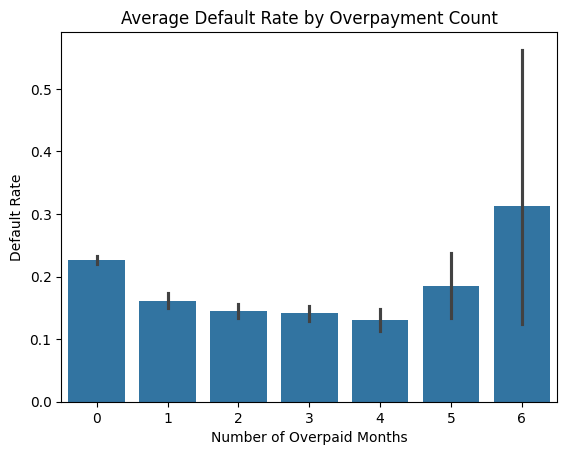

In [46]:
sns.barplot(x="overpayment_count", y=y, data=X)
plt.title("Average Default Rate by Overpayment Count")
plt.xlabel("Number of Overpaid Months")
plt.ylabel("Default Rate")
plt.show()

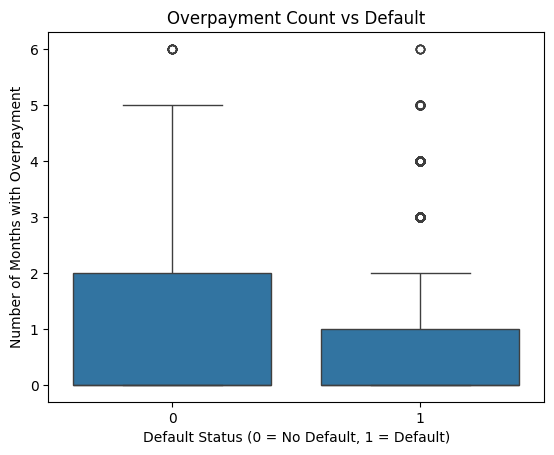

In [47]:
sns.boxplot(x=y, y="overpayment_count", data=X)
plt.title("Overpayment Count vs Default")
plt.xlabel("Default Status (0 = No Default, 1 = Default)")
plt.ylabel("Number of Months with Overpayment")
plt.show()

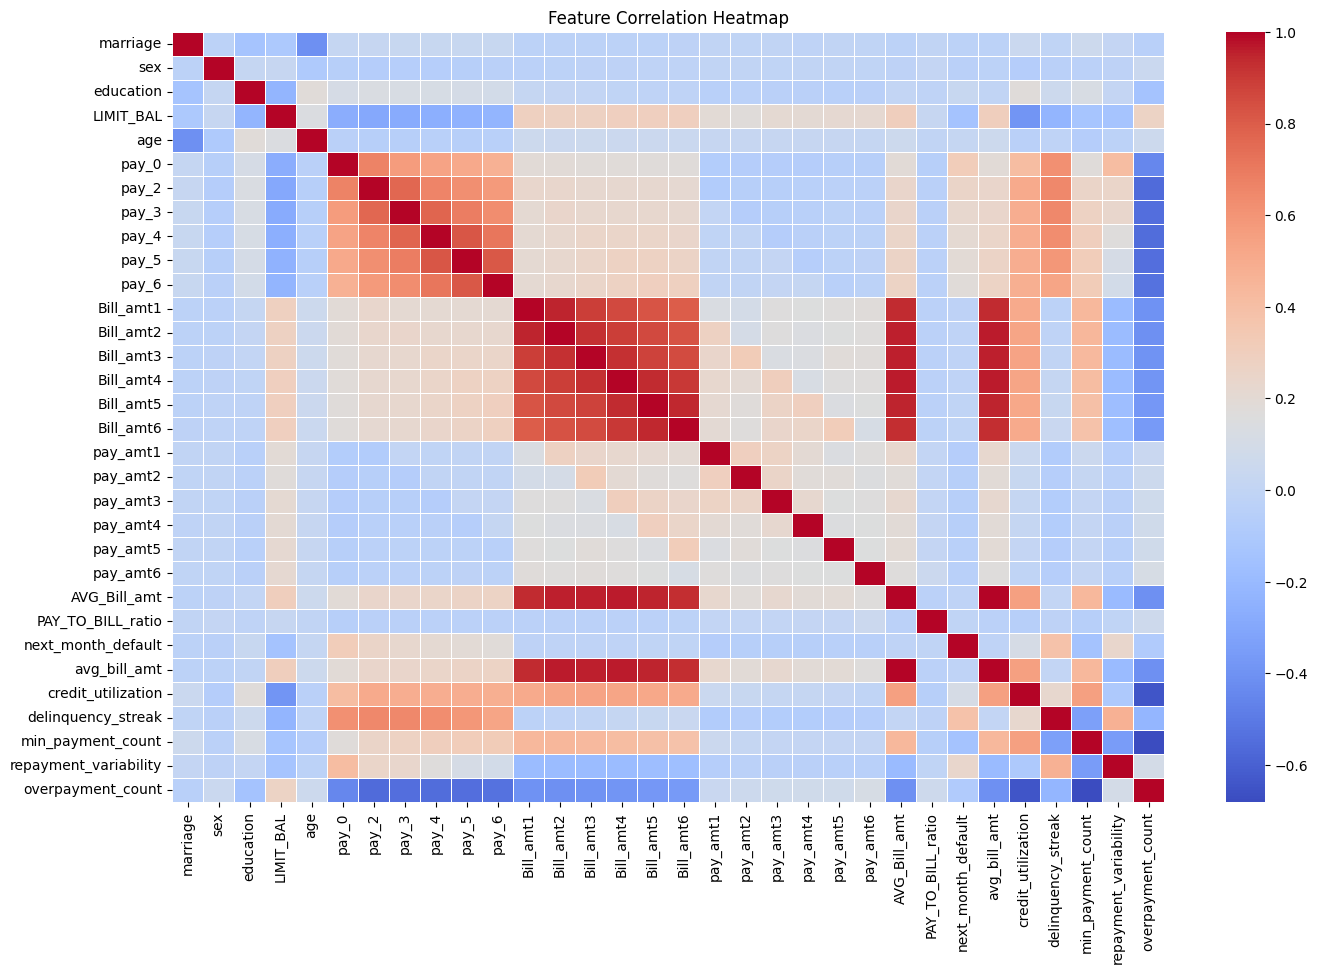

In [48]:
# Correlation matrix
train_temp = train.copy()
train_temp["next_month_default"] = y
corr = train_temp.corr()

plt.figure(figsize=(16, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

next_month_default       1.000000
delinquency_streak       0.379885
pay_0                    0.312943
pay_2                    0.252125
repayment_variability    0.234133
pay_3                    0.226015
pay_4                    0.207488
pay_5                    0.196329
pay_6                    0.180387
min_payment_count        0.147657
LIMIT_BAL                0.146010
credit_utilization       0.111868
overpayment_count        0.089178
pay_amt1                 0.068882
pay_amt4                 0.053624
pay_amt2                 0.053623
pay_amt3                 0.050925
pay_amt6                 0.047116
pay_amt5                 0.046960
sex                      0.037537
education                0.032346
marriage                 0.029242
Bill_amt1                0.021729
age                      0.017703
Bill_amt3                0.016706
Bill_amt2                0.016079
AVG_Bill_amt             0.014694
avg_bill_amt             0.014674
Bill_amt4                0.012032
Bill_amt5     

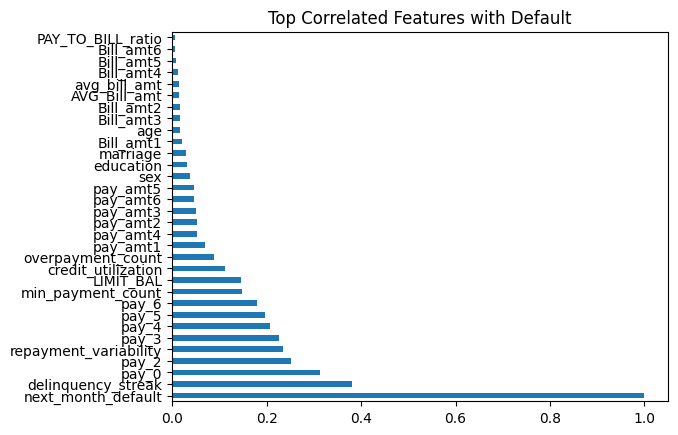

In [49]:
# Sort by correlation with target
top_corrs = corr["next_month_default"].abs().sort_values(ascending=False)[:]
print(top_corrs)

top_corrs.plot(kind="barh", title="Top Correlated Features with Default")
plt.show()

In [50]:
top_features = top_corrs[top_corrs > 0.1].drop("next_month_default").index.tolist()

In [51]:
top_features

['delinquency_streak',
 'pay_0',
 'pay_2',
 'repayment_variability',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
 'min_payment_count',
 'LIMIT_BAL',
 'credit_utilization']

In [52]:
train_reduced = train[top_features + ["next_month_default"]]
test_reduced = test[top_features]

In [53]:
train_reduced.head()

,delinquency_streak,pay_0,pay_2,repayment_variability,pay_3,pay_4,pay_5,pay_6,min_payment_count,LIMIT_BAL,credit_utilization,next_month_default
0,3,2,2,1.095445,2,0,0,0,3,60000,0.691847,0
1,0,0,0,0.983192,-2,-2,-1,0,3,290000,0.008742,0
2,0,0,0,0.000000,0,0,0,0,6,180000,0.280119,0
3,0,0,0,0.000000,0,0,0,0,6,210000,0.410616,0
4,0,-2,-2,0.000000,-2,-2,-2,-2,0,280000,0.042194,0


In [54]:
y = train_reduced["next_month_default"]
X = train_reduced.drop("next_month_default", axis=1)

In [55]:
# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test_final = scaler.transform(test_reduced)

In [57]:
# Class Imbalance Handling
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [58]:
X_train.shape

(32690, 11)

In [ ]:
# Model Training and Evaluation Function
def evaluate_model(model, name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"==== {name} Evaluation ====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
    print("Recall:", recall_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")


In [60]:
scale_pos_weight = train["next_month_default"].value_counts()[0] / train["next_month_default"].value_counts()[1]
scale_pos_weight

np.float64(4.252132307052215)

In [61]:
train["next_month_default"].value_counts()[0]

np.int64(20440)

In [62]:
# Try Multiple Models

# Logistic Regression
lr = LogisticRegression(class_weight='balanced')
evaluate_model(lr, "Logistic Regression")

# XGBoost
xgb = XGBClassifier(scale_pos_weight = train["next_month_default"].value_counts()[0] / train["next_month_default"].value_counts()[1], use_label_encoder=False, eval_metric='logloss')
evaluate_model(xgb, "XGBoost")

# LightGBM
lgbm = LGBMClassifier()
evaluate_model(lgbm, "LightGBM")


==== Logistic Regression Evaluation ====
Accuracy: 0.7625742574257426
F1 Score: 0.49259415996614475
F2 Score: 0.5566182096403979
Recall: 0.6094240837696335
Precision: 0.4133522727272727
ROC AUC: 0.7598854432362286
Confusion Matrix:
 [[3269  826]
 [ 373  582]]


==== XGBoost Evaluation ====
Accuracy: 0.5308910891089109
F1 Score: 0.39115908506810587
F2 Score: 0.5632030787448195
Recall: 0.7968586387434555
Precision: 0.25919618528610355
ROC AUC: 0.733193717277487
Confusion Matrix:
 [[1920 2175]
 [ 194  761]]


[LightGBM] [Info] Number of positive: 16345, number of negative: 16345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2270
[LightGBM] [Info] Number of data points in the train set: 32690, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> init

In [63]:
# XGBoost
xgb = XGBClassifier(scale_pos_weight = train["next_month_default"].value_counts()[0] / train["next_month_default"].value_counts()[1], use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [64]:
# Predict probabilities
y_train_proba = xgb.predict_proba(X_train)[:, 1]
y_test_proba = xgb.predict_proba(X_test)[:, 1]

# Apply threshold = 0.4
y_train_pred = (y_train_proba > 0.4).astype(int)
y_test_pred = (y_test_proba > 0.4).astype(int)

# Evaluate
print("Train Metrics (threshold=0.4):")
print(classification_report(y_test, y_test_pred))

print("Validation F2 Score:", fbeta_score(y_test, y_test_pred, beta=2))

Train Metrics (threshold=0.4):
              precision    recall  f1-score   support

           0       0.91      0.34      0.49      4095
           1       0.23      0.86      0.36       955

    accuracy                           0.43      5050
   macro avg       0.57      0.60      0.43      5050
weighted avg       0.78      0.43      0.47      5050

Validation F2 Score: 0.5557065217391305


In [65]:
from sklearn.metrics import fbeta_score

# Predict probabilities
y_val_proba = xgb.predict_proba(X_test)[:, 1]

# Try thresholds
thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.9]
f2_scores = [fbeta_score(y_test, y_val_proba > t, beta=2) for t in thresholds]

# Best threshold
best_threshold = thresholds[np.argmax(f2_scores)]
print("Best threshold (F2 optimized):", best_threshold)
print("Best F2 score:", np.max(f2_scores))




Best threshold (F2 optimized): 0.45
Best F2 score: 0.5634898190045249


In [66]:
X_test_df = pd.DataFrame(X_test, columns=X.columns)

In [67]:
# Create SHAP explainer for tree-based models
explainer = shap.Explainer(xgb, X_test_df)

# SHAP values for validation set
shap_values = explainer(X_test_df)

 99%|===================| 5014/5050 [00:18<00:00]       

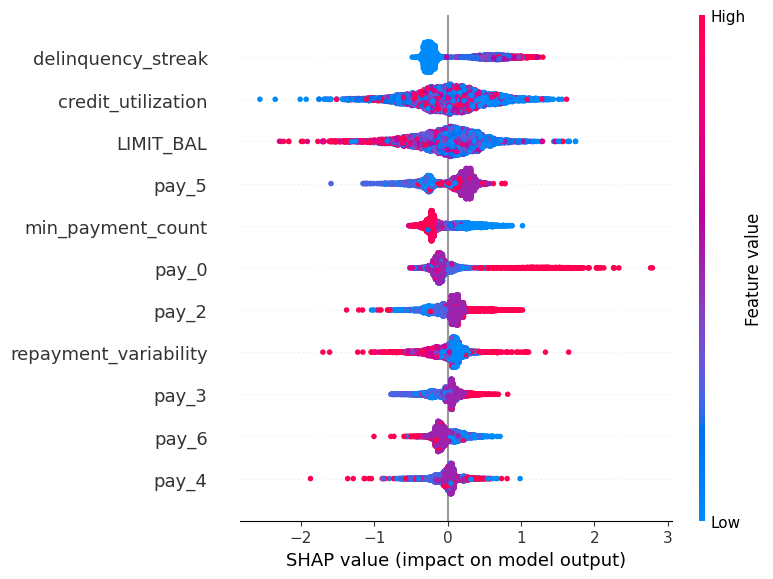

In [68]:
# Plot summary of feature importance
shap.summary_plot(shap_values, features=X_test_df, feature_names=X.columns)


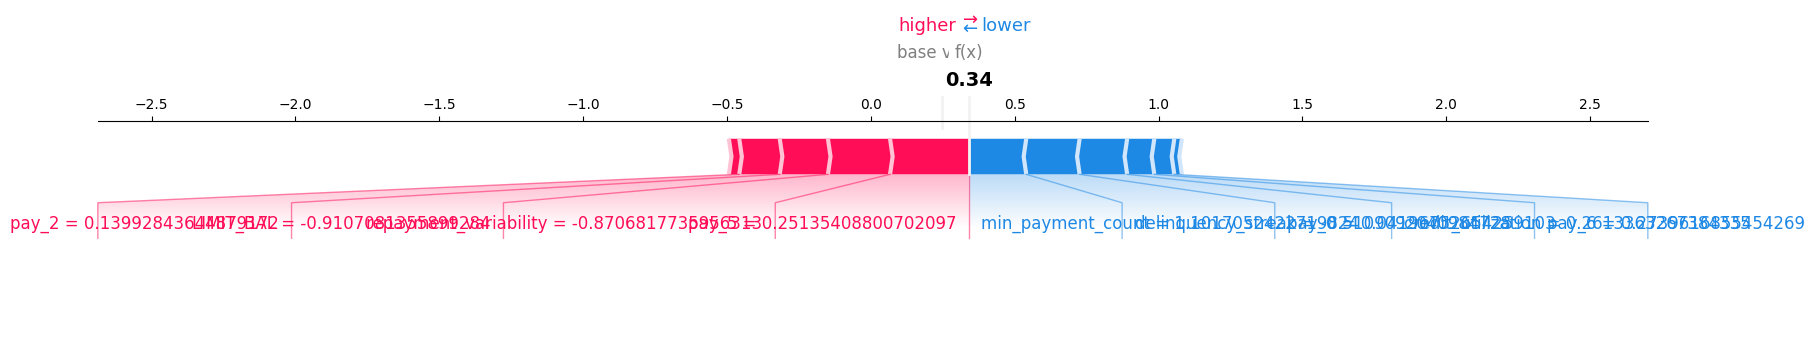

In [69]:
# Choose an instance (e.g., first one)
shap.plots.force(shap_values[0], matplotlib=True)


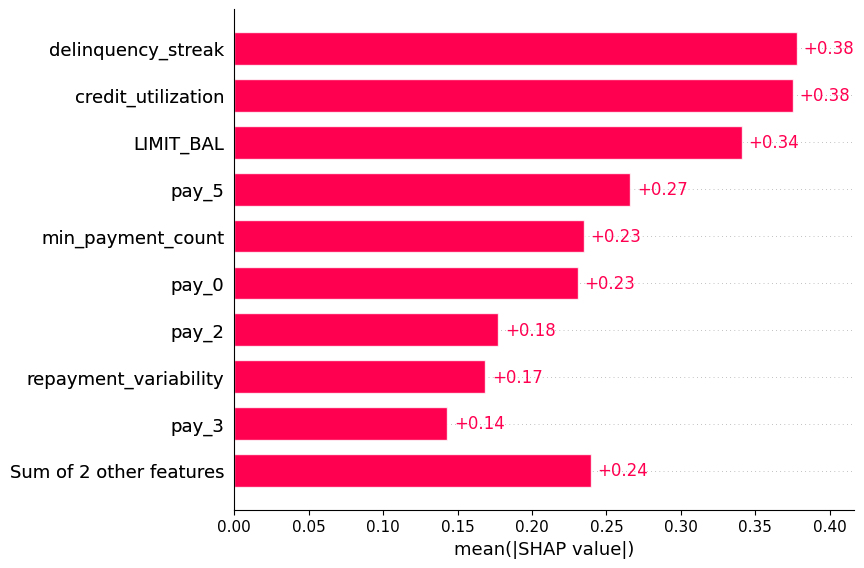

In [70]:
# Global feature ranking
shap.plots.bar(shap_values)

# **Without Dropping any column**

In [71]:
y_new = train["next_month_default"]
X_new = train.drop("next_month_default", axis=1)

In [72]:
X_new.isnull().sum()

,0
marriage,0
sex,0
education,0
LIMIT_BAL,0
age,0
pay_0,0
pay_2,0
pay_3,0
pay_4,0
pay_5,0


In [73]:
X_new["age"].fillna(X_new["age"].median(), inplace=True)

In [74]:
# Train-Test Split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)



In [75]:
# Scaling
scaler = StandardScaler()
X_train_new = scaler.fit_transform(X_train_new)
X_test_new = scaler.transform(X_test_new)
X_test_final_new = scaler.transform(test)

In [76]:
# Class Imbalance Handling
sm = SMOTE(random_state=42)
X_train_new, y_train_new = sm.fit_resample(X_train_new, y_train_new)

In [77]:
# Model Training and Evaluation Function
def evaluate_model(model, name="Model"):
    model.fit(X_train_new, y_train_new)
    y_pred_new = model.predict(X_test_new)
    y_proba_new = model.predict_proba(X_test_new)[:, 1]

    print(f"==== {name} Evaluation ====")
    print("Accuracy:", accuracy_score(y_test_new, y_pred_new))
    print("F1 Score:", f1_score(y_test_new, y_pred_new))
    print("F2 Score:", fbeta_score(y_test_new, y_pred_new, beta=2))
    print("Recall:", recall_score(y_test_new, y_pred_new))
    print("Precision:", precision_score(y_test_new, y_pred_new))
    print("ROC AUC:", roc_auc_score(y_test_new, y_proba_new))
    print("Confusion Matrix:\n", confusion_matrix(y_test_new, y_pred_new))
    print("\n")


In [78]:
# Try Multiple Models

# Logistic Regression
lr_1 = LogisticRegression(class_weight='balanced')
evaluate_model(lr_1, "Logistic Regression")

# XGBoost
xgb_1 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
evaluate_model(xgb_1, "XGBoost")

# LightGBM
lgbm_1 = LGBMClassifier()
evaluate_model(lgbm_1, "LightGBM")

==== Logistic Regression Evaluation ====
Accuracy: 0.7576237623762376
F1 Score: 0.49169435215946844
F2 Score: 0.5613502749857766
Recall: 0.6198952879581152
Precision: 0.4074328974535444
ROC AUC: 0.7676292759015272
Confusion Matrix:
 [[3234  861]
 [ 363  592]]


==== XGBoost Evaluation ====
Accuracy: 0.8277227722772277
F1 Score: 0.45962732919254656
F2 Score: 0.4134078212290503
Recall: 0.387434554973822
Precision: 0.5648854961832062
ROC AUC: 0.7601593054996197
Confusion Matrix:
 [[3810  285]
 [ 585  370]]


[LightGBM] [Info] Number of positive: 16345, number of negative: 16345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7792
[LightGBM] [Info] Number of data points in the train set: 32690, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> inits

In [79]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=80, random_state=42)
ada.fit(X_train_new, y_train_new)

# Predict with threshold = 0.4
y_ada_proba = ada.predict_proba(X_test_new)[:, 1]
y_ada_pred = (y_ada_proba > 0.4).astype(int)

print("AdaBoost (Threshold=0.4)")
print(classification_report(y_test_new, y_ada_pred))
print("F2 Score:", fbeta_score(y_test_new, y_ada_pred, beta=2))

AdaBoost (Threshold=0.4)
              precision    recall  f1-score   support

           0       0.96      0.10      0.19      4095
           1       0.20      0.98      0.34       955

    accuracy                           0.27      5050
   macro avg       0.58      0.54      0.26      5050
weighted avg       0.81      0.27      0.22      5050

F2 Score: 0.5556874851579198


In [80]:
# Predict probabilities
y_train_proba_new = xgb_1.predict_proba(X_train_new)[:, 1]
y_test_proba_new = xgb_1.predict_proba(X_test_new)[:, 1]

# Apply threshold = 0.4
y_train_pred_new = (y_train_proba_new > 0.4).astype(int)
y_test_pred_new = (y_test_proba_new > 0.4).astype(int)

print(classification_report(y_test_new, y_test_pred_new))

print("Validation F2 Score:", fbeta_score(y_test_new, y_test_pred_new, beta=2))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      4095
           1       0.49      0.47      0.48       955

    accuracy                           0.81      5050
   macro avg       0.69      0.68      0.68      5050
weighted avg       0.81      0.81      0.81      5050

Validation F2 Score: 0.47815072830905636


In [81]:
logreg = LogisticRegression(class_weight='balanced', penalty='l2', C=1.0, solver='liblinear')
logreg.fit(X_train_new, y_train_new)

# Predict with threshold = 0.2
y_log_proba = logreg.predict_proba(X_test_new)[:, 1]
y_log_pred = (y_log_proba > 0.4).astype(int)

print("Logistic Regression (Threshold=0.4)")
print(classification_report(y_test_new, y_log_pred))
print("F2 Score:", fbeta_score(y_test_new, y_log_pred, beta=2))


Logistic Regression (Threshold=0.4)
              precision    recall  f1-score   support

           0       0.92      0.62      0.74      4095
           1       0.32      0.76      0.45       955

    accuracy                           0.65      5050
   macro avg       0.62      0.69      0.59      5050
weighted avg       0.80      0.65      0.69      5050

F2 Score: 0.5950819672131148


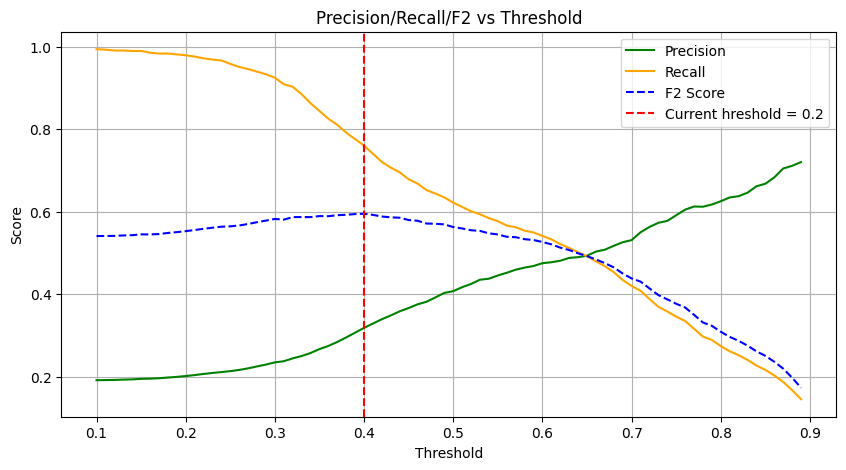

In [82]:
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, precision_recall_curve
import matplotlib.pyplot as plt

# Predict probabilities on validation set
y_proba = logreg.predict_proba(X_test_new)[:, 1]

# Sweep through thresholds
thresholds = np.arange(0.1, 0.9, 0.01)
precisions = []
recalls = []
f1s = []
f2s = []

for t in thresholds:
    preds = (y_proba > t).astype(int)
    precisions.append(precision_score(y_test_new, preds))
    recalls.append(recall_score(y_test_new, preds))
    f1s.append(f1_score(y_test_new, preds))
    f2s.append(fbeta_score(y_test_new, preds, beta=2))

# Plot
plt.figure(figsize=(10,5))
plt.plot(thresholds, precisions, label='Precision', color='green')
plt.plot(thresholds, recalls, label='Recall', color='orange')
plt.plot(thresholds, f2s, label='F2 Score', color='blue', linestyle='--')
plt.axvline(x=0.4, color='red', linestyle='--', label='Current hreshold = 0.2')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision/Recall/F2 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [83]:
# Predict probabilities
y_val_proba = logreg.predict_proba(X_test_new)[:, 1]

# Try thresholds
thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.9]
f2_scores = [fbeta_score(y_test, y_val_proba > t, beta=2) for t in thresholds]

# Best threshold
best_threshold = thresholds[np.argmax(f2_scores)]
print("Best threshold (F2 optimized):", best_threshold)
print("Best F2 score:", np.max(f2_scores))


Best threshold (F2 optimized): 0.4
Best F2 score: 0.5950819672131148


In [93]:
# Final Prediction for Submission
y_test_final_proba = (logreg.predict_proba(X_test_final_new)[:, 1])


# Apply threshold
y_test_final_pred = (y_test_final_proba > 0.4).astype(int)

# Prepare submission
submission = pd.DataFrame({
    "Customer_ID": test_id,
    "next_month_default (0 or 1)": y_test_final_pred
})

# Save to CSV
submission.to_csv("submission_22118069.csv", index=False)

# **SHAP Explaination**

In [85]:
X_test_new_df = pd.DataFrame(X_test_new, columns=X_new.columns)

In [86]:
# Create SHAP explainer for tree-based models
explainer = shap.Explainer(logreg, X_test_new_df)

# SHAP values for validation set
shap_values = explainer(X_test_new_df)

In [87]:
X_new.columns

Index(['marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2',
       'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'avg_bill_amt',
       'credit_utilization', 'delinquency_streak', 'min_payment_count',
       'repayment_variability', 'overpayment_count'],
      dtype='object')

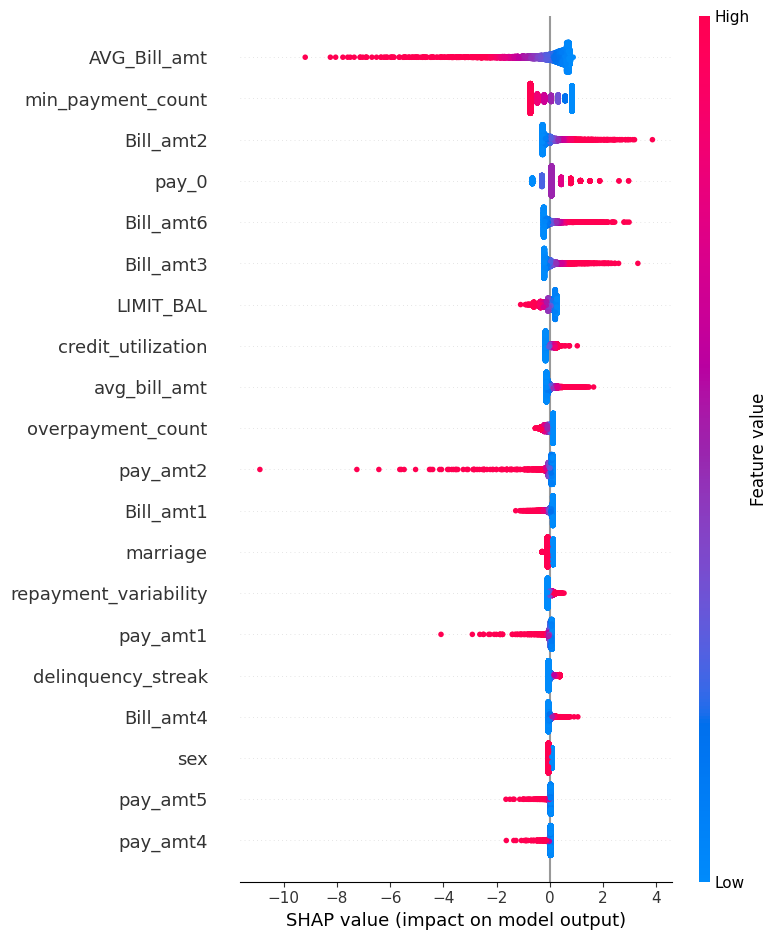

In [88]:
# Plot summary of feature importance
shap.summary_plot(shap_values, features=X_test_new_df, feature_names=X_new.columns)


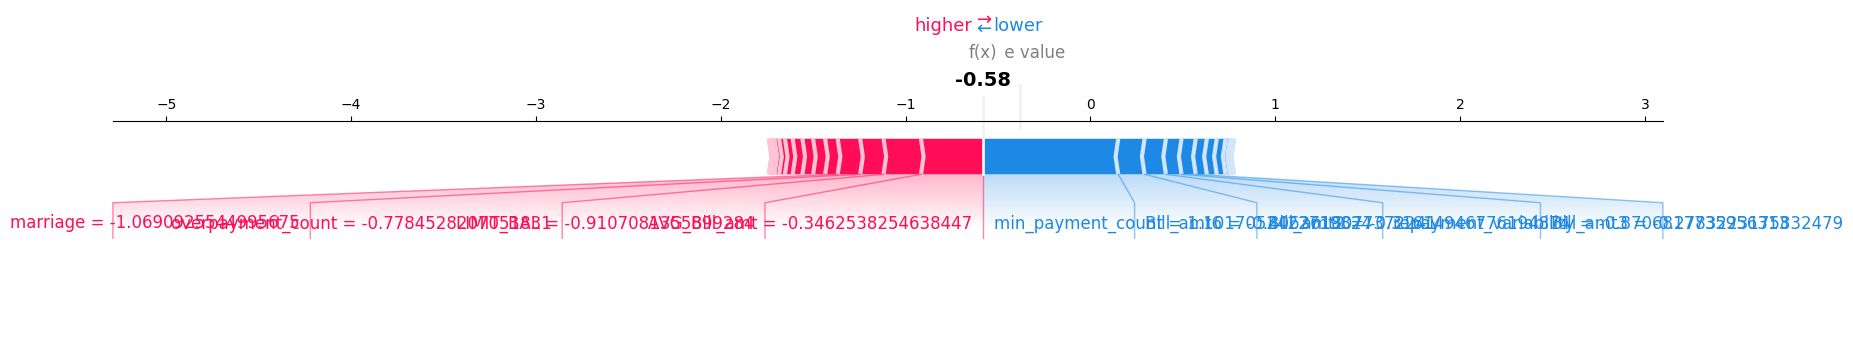

In [89]:
# Choose an instance (e.g., first one)
shap.plots.force(shap_values[0], matplotlib=True)


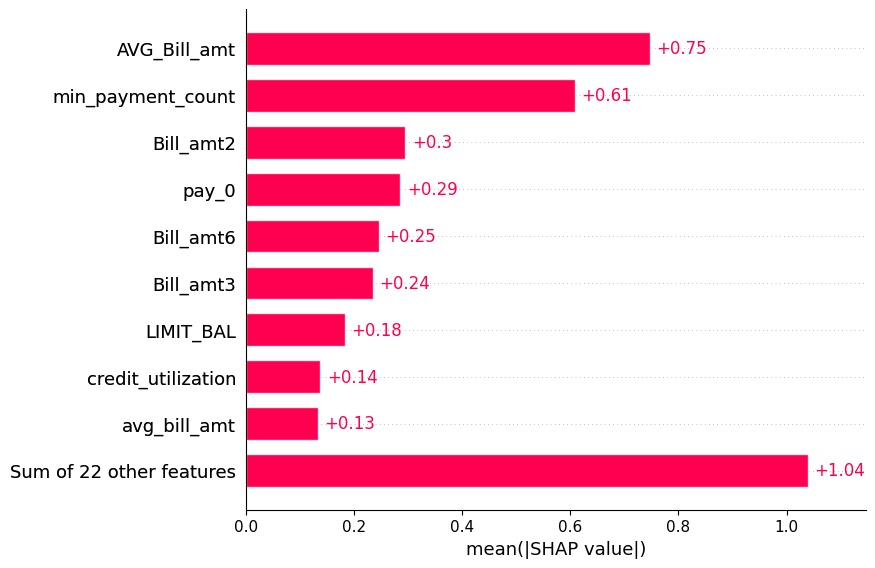

In [90]:
shap.plots.bar(shap_values)


In [91]:
df = pd.read_csv("submission_22118069.csv")

In [92]:
df["next_month_default"].value_counts()

,count
next_month_default,
0,2716
1,2300
